# ruBERT Fine-Tuning Tutorial with PyTorch


## Advantages of Fine-Tuning



In this colab, we will use ruBERT to train a text classifier. Specifically, we will take the pre-trained ruBERT model, add an untrained layer of neurons on the end, and train the new model for our classification task. Why do this rather than train a train a specific deep learning model (a CNN, BiLSTM, etc.) that is well suited for the specific NLP task you need? 

1. **Quicker Development**

    * First, the pre-trained ruBERT model weights already encode a lot of information about our language. As a result, it takes much less time to train our fine-tuned model - it is as if we have already trained the bottom layers of our network extensively and only need to gently tune them while using their output as features for our classification task. In fact, the authors recommend only 2-4 epochs of training for fine-tuning ruBERT on a specific NLP task (compared to the hundreds of GPU hours needed to train the original ruBERT model or a LSTM from scratch!). 

2. **Less Data**

    * In addition and perhaps just as important, because of the pre-trained weights this method allows us to fine-tune our task on a much smaller dataset than would be required in a model that is built from scratch. A major drawback of NLP models built from scratch is that we often need a prohibitively large dataset in order to train our network to reasonable accuracy, meaning a lot of time and energy had to be put into dataset creation. By fine-tuning ruBERT, we are now able to get away with training a model to good performance on a much smaller amount of training data.

3. **Better Results**

    * Finally, this simple fine-tuning procedure (typically adding one fully-connected layer on top of ruBERT and training for a few epochs) was shown to achieve state of the art results with minimal task-specific adjustments for a wide variety of tasks: classification, language inference, semantic similarity, question answering, etc. Rather than implementing custom and sometimes-obscure architetures shown to work well on a specific task, simply fine-tuning ruBERT is shown to be a better (or at least equal) alternative.


# 1. Setup

## 1.0. Setting metaparameters

In [9]:
main_characters = ['ДЖОУИ', 'МОНИКА', 'РЕЙЧЕЛ', 'РОСС', 'ФИБИ', 'ЧЕНДЛЕР']
labels_to_chars = dict(enumerate(main_characters))
chars_to_labels = {v: k for k, v in labels_to_chars.items()}
labels_to_chars, chars_to_labels

({0: 'ДЖОУИ', 1: 'МОНИКА', 2: 'РЕЙЧЕЛ', 3: 'РОСС', 4: 'ФИБИ', 5: 'ЧЕНДЛЕР'},
 {'ДЖОУИ': 0, 'МОНИКА': 1, 'РЕЙЧЕЛ': 2, 'РОСС': 3, 'ФИБИ': 4, 'ЧЕНДЛЕР': 5})

In [10]:
MAX_LENGTH = 100
NUMBER_OF_CLASSES = len(main_characters)

## 1.1. Using Colab GPU for Training



Google Colab offers free GPUs and TPUs! Since we'll be training a large neural network it's best to take advantage of this (in this case we'll attach a GPU), otherwise training will take a very long time.

A GPU can be added by going to the menu and selecting:

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Then run the following cell to confirm that the GPU is detected.

In [3]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In order for torch to use the GPU, we need to identify and specify the GPU as the device. Later, in our training loop, we will load data onto the device. 

In [11]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: GeForce RTX 2080


## 1.2. Installing the Hugging Face Library


In [5]:
!pip install transformers

# 2. Load Friends Dataset

In [6]:
!git clone https://github.com/Alenush/style_transfer_sirius2021summer.git

fatal: целевой путь «style_transfer_sirius2021summer» уже существует и не является пустым каталогом.


In [7]:
%%bash

pushd style_transfer_sirius2021summer/
git checkout master
popd

~/style_transfer_sirius2021summer ~
D	data/small_experiments/_test_corpus.txt
D	data/small_experiments/models_testing.csv
Ваша ветка обновлена в соответствии с «origin/master».
~


Уже на «master»


In [8]:
!head style_transfer_sirius2021summer/data/scripts/russian/РЕЙЧЕЛ.txt  --bytes=2206

Боже, привет, Моника! Я только что подошел к твоему дому, а тебя там не было, а потом этот парень с большим молотком сказал, что ты мог бы быть здесь, а ты здесь! Привет, конечно! О боже, ну, это началось примерно за полчаса до свадьбы. Я был в комнате, где хранились все подарки, и смотрел на этот соусник. Это действительно великолепный соусник из Ламожа. Когда внезапно - Sweet 'n' Lo? - я понял, что меня больше возбуждает этот соусник, чем Барри! А потом я действительно испугался, и тут меня осенило: насколько Барри похож на мистера Картофельная Голова. Понимаешь, я имею в виду, он всегда выглядел знакомым, но. В любом случае, мне просто нужно было выбраться оттуда, и я начал задаваться вопросом: "Почему я это делаю и для кого я это делаю?". Так или иначе, я просто не знал, куда идти, и я знаю, что мы с тобой вроде как разошлись, но ты единственный человек, которого я знал, кто жил здесь, в городе. Ох, я вроде как надеялся, что это не проблема. Папа, я просто, я не могу выйти за него 

In [9]:
!pip install rusenttokenize

In [10]:
from rusenttokenize import ru_sent_tokenize

RUSSIAN_SCRIPTS_PATH = 'style_transfer_sirius2021summer/data/scripts/russian'
RUSSIAN_NAMES = [
    'ДЖОУИ',
    'РЕЙЧЕЛ',
    'ФИБИ',
    'МОНИКА',
    'РОСС',
    'ЧЕНДЛЕР'
]
SENTS_BY_NAME = { name : [] for name in RUSSIAN_NAMES }

for name in RUSSIAN_NAMES:
    with open(f'{RUSSIAN_SCRIPTS_PATH}/{name}.txt', 'r') as f:
        lines = f.readlines()[0]

    SENTS_BY_NAME[name] = ru_sent_tokenize(lines)

SENTS_BY_NAME['ДЖОУИ'][:20]

['Да ладно, ты встречаешься с этим парнем!',
 'С ним должно быть что-то не так!',
 'Вместо?',
 'Никогда не видел этого сна.',
 'Этот парень здоровается, я хочу убить себя.',
 'А ты никогда не знал, что она лесбиянка.',
 'Хорошо, Росс, смотри.',
 'Вы сейчас чувствуете сильную боль.',
 'Ты сердишься.',
 'Тебе больно.',
 'Могу я сказать вам ответ?',
 'Ленточный стык!',
 'Да ладно, ты один!',
 'Есть гормоны!',
 'Я говорю: столкните ее с лестницы.',
 'Эй, тебе что-нибудь нужно, ты всегда можешь прийти к Джоуи.',
 'Мы с Чендлером живем через холл.',
 'И он много раз уезжает.',
 'Что, вроде есть правило или что-то в этом роде?',
 'Кто такой Пол?']

In [11]:
import pandas as pd
import numpy as np
from tqdm import tqdm

tqdm.pandas()

In [12]:
data = [[], []]

for name in RUSSIAN_NAMES:
    data[0].extend([name] * len(SENTS_BY_NAME[name]))
    data[1].extend(SENTS_BY_NAME[name])

columns = ['Character', 'Phrase']
df_ = pd.DataFrame(data, index=columns).T
# df_ = df_[df_.Phrase.apply(lambda x: len(x.split()) > 3)]
df_.shape

(85356, 2)

In [13]:
df = df_.sample(frac=1).reset_index(drop=True)
df

,Character,Phrase
0,ДЖОУИ,Ваш кошелек!
1,ДЖОУИ,"Я знаю, что вы видели того парня, я думал, мож..."
2,ДЖОУИ,"Ну, они перевели меня на Hombre."
3,ДЖОУИ,Что ты говоришь?
4,ФИБИ,Я просто машина!
5,РОСС,"И это должно окончательно доказать, что идея П..."
6,МОНИКА,"Ты прав, мне очень жаль."
7,ФИБИ,Ох!
8,ЧЕНДЛЕР,Они ошиблись.
9,ДЖОУИ,"Как в конце танца, ЭЙ!"


# Preprocess Friends Dataset

In [14]:
import numpy as np

In [15]:
!pip install natasha pymorphy2

In [16]:
import re
from natasha import (
    Segmenter,
    MorphVocab,
    
    NewsEmbedding,
    NewsMorphTagger,
    NewsSyntaxParser,
    NewsNERTagger,
    
    PER,

    Doc
)

import pymorphy2
morph = pymorphy2.MorphAnalyzer()

segmenter = Segmenter()
emb = NewsEmbedding()
ner_tagger = NewsNERTagger(emb)

def remove_by_indices(x, indices):
    new_str = ""
    curr_index = 0
    end = 0
    for start, end in indices:
        while curr_index < start:
            new_str += x[curr_index]
            curr_index += 1
        curr_index = end + 1
    new_str += x[end:]
    return new_str

def lemmatize(text):
    words = text.split() # разбиваем текст на слова
    res = list()
    for word in words:
        p = morph.parse(word)[0]
        res.append(p.normal_form)

    return res

def base_form(text: str) -> str:
    char_only = re.sub('[^а-яА-Я ]', '', text) 
    new_str = str(re.sub(' +', ' ', char_only))
    #print(new_str)
    doc = Doc(new_str)
    doc.segment(segmenter)
    doc.tag_ner(ner_tagger)
    #return new_str.strip()
    indices = []
    for span in doc.spans:
        if span.type == "PER":
            indices.append((span.start, span.stop))
    without_names = remove_by_indices(new_str, indices)
    new_str = str(re.sub(' +', ' ', without_names))
    lemmatized = ' '.join(lemmatize(new_str))
    return lemmatized.lower().strip()

text = "Миссис Уоллес, я доктор Дрейк Рамори, нейрохирург вашей сестры."
base_form(text)

'я доктор нейрохирург ваш сестра'

In [17]:
df_["Base_Phrase"] = df_["Phrase"].progress_apply(base_form)

100%|██████████| 85356/85356 [04:42<00:00, 301.70it/s]


In [18]:
df_

,Character,Phrase,Base_Phrase
0,ДЖОУИ,"Да ладно, ты встречаешься с этим парнем!",да ладный ты встречаться с это парень
1,ДЖОУИ,С ним должно быть что-то не так!,с они должный быть чтоть не так
2,ДЖОУИ,Вместо?,вместо
3,ДЖОУИ,Никогда не видел этого сна.,никогда не видеть это сон
4,ДЖОУИ,"Этот парень здоровается, я хочу убить себя.",этот парень здороваться я хотеть убить себя
5,ДЖОУИ,"А ты никогда не знал, что она лесбиянка.",а ты никогда не знать что она лесбиянка
6,ДЖОУИ,"Хорошо, Росс, смотри.",смотреть
7,ДЖОУИ,Вы сейчас чувствуете сильную боль.,вы сейчас чувствовать сильный боль
8,ДЖОУИ,Ты сердишься.,ты сердиться
9,ДЖОУИ,Тебе больно.,ты больно


In [19]:
suspisious_phrases = set(df_["Base_Phrase"].value_counts()[df_["Base_Phrase"].value_counts() > 1].index)
len(suspisious_phrases)

3543

In [20]:
phrase_to_character = dict()
to_del = set()

for index, row in df_.iterrows():
    phrase = row["Base_Phrase"]
    hero = row["Character"]
    if phrase in suspisious_phrases:
        if phrase in phrase_to_character:
            if hero not in phrase_to_character[phrase]:
                phrase_to_character[phrase].append(hero)
        else:
            phrase_to_character[phrase] = [hero]
            
list(phrase_to_character.items())[:20]

[('смотреть', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('ты больно', ['ДЖОУИ', 'РЕЙЧЕЛ']),
 ('кто такой', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('подождать', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('что это', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('о чем ты говорить',
  ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('поздравлять', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('добрый утро', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'РОСС', 'ЧЕНДЛЕР']),
 ('сомневаться', ['ДЖОУИ', 'ЧЕНДЛЕР']),
 ('не мочь поверить в то что я здесь слышать', ['ДЖОУИ', 'ФИБИ']),
 ('да верно', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('ты серьёзно', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'ЧЕНДЛЕР']),
 ('всегда', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС']),
 ('ага', ['ДЖОУИ', 'РЕЙЧЕЛ', 'ФИБИ', 'МОНИКА', 'РОСС', 'ЧЕНДЛЕР']),
 ('

In [21]:
df_vc = df_["Base_Phrase"].value_counts()
df_vc = df_vc[df_vc > 1]
vc = df_vc.to_dict()

list(vc.items())[:20]

[('', 2584),
 ('хорошо', 1995),
 ('привет', 1990),
 ('ага', 1680),
 ('нет', 1205),
 ('что', 1063),
 ('ой', 734),
 ('бог мой', 602),
 ('да', 475),
 ('спасибо', 431),
 ('ух ты', 348),
 ('знать', 292),
 ('отлично', 282),
 ('в сам дело', 279),
 ('верно', 253),
 ('эй', 247),
 ('давать', 236),
 ('знать что', 219),
 ('почему', 218),
 ('это', 187)]

In [22]:
df_vc = df_vc.reset_index()
df_vc.columns = ['Base_Phrase', 'Count']
df_vc

,Base_Phrase,Count
0,,2584
1,хорошо,1995
2,привет,1990
3,ага,1680
4,нет,1205
5,что,1063
6,ой,734
7,бог мой,602
8,да,475
9,спасибо,431


In [23]:
df_vc["Character"] = df_vc["Base_Phrase"].apply(lambda x: phrase_to_character[x])
df_vc

,Base_Phrase,Count,Character
0,,2584,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
1,хорошо,1995,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
2,привет,1990,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
3,ага,1680,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
4,нет,1205,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
5,что,1063,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
6,ой,734,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
7,бог мой,602,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
8,да,475,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"
9,спасибо,431,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]"


In [24]:
df_vc["Char_count"] = df_vc["Character"].apply(lambda x: len(x))
df_vc

,Base_Phrase,Count,Character,Char_count
0,,2584,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
1,хорошо,1995,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
2,привет,1990,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
3,ага,1680,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
4,нет,1205,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
5,что,1063,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
6,ой,734,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
7,бог мой,602,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
8,да,475,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
9,спасибо,431,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6


In [25]:
unconfident_phrases = df_vc[(df_vc.Count >= 4) & (df_vc.Char_count > 2)].reset_index(drop=True)
unconfident_phrases

,Base_Phrase,Count,Character,Char_count
0,,2584,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
1,хорошо,1995,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
2,привет,1990,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
3,ага,1680,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
4,нет,1205,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
5,что,1063,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
6,ой,734,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
7,бог мой,602,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
8,да,475,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6
9,спасибо,431,"[ДЖОУИ, РЕЙЧЕЛ, ФИБИ, МОНИКА, РОСС, ЧЕНДЛЕР]",6


In [26]:
bad_phr = list(unconfident_phrases["Base_Phrase"])
with open("unconfident_base_phrases.txt", "w") as f:
    f.write('\n'.join(bad_phr))

bad_phr[:20]

['',
 'хорошо',
 'привет',
 'ага',
 'нет',
 'что',
 'ой',
 'бог мой',
 'да',
 'спасибо',
 'ух ты',
 'знать',
 'отлично',
 'в сам дело',
 'верно',
 'эй',
 'давать',
 'знать что',
 'почему',
 'это']

In [27]:
print(f'Cleaning {int(100 * unconfident_phrases["Count"].sum()/(df.shape[0]))}% of sentences')

Cleaning 32% of sentences


In [28]:
df_clean = df_[~df_["Base_Phrase"].isin(bad_phr)].reset_index(drop=True)
df_clean.columns = ["label", "sentence", "base_sentence"]
df_clean["label"] = df_clean["label"].apply(lambda x: chars_to_labels[x])
df_clean

,label,sentence,base_sentence
0,0,"Да ладно, ты встречаешься с этим парнем!",да ладный ты встречаться с это парень
1,0,С ним должно быть что-то не так!,с они должный быть чтоть не так
2,0,Вместо?,вместо
3,0,Никогда не видел этого сна.,никогда не видеть это сон
4,0,"Этот парень здоровается, я хочу убить себя.",этот парень здороваться я хотеть убить себя
5,0,"А ты никогда не знал, что она лесбиянка.",а ты никогда не знать что она лесбиянка
6,0,Вы сейчас чувствуете сильную боль.,вы сейчас чувствовать сильный боль
7,0,Ты сердишься.,ты сердиться
8,0,Тебе больно.,ты больно
9,0,Могу я сказать вам ответ?,мочь я сказать вы ответ


In [29]:
df = df_clean.sample(frac=1).reset_index(drop=True)
df

,label,sentence,base_sentence
0,2,"Вы знаете, как будут имена наших детей.",вы знать как быть имя наш ребёнок
1,0,Я забыл свою биту.,я забыть свой бит
2,0,"Нет-нет, стой здесь.",стоить здесь
3,1,Ну не так уж много ребят.,ну не так уж много ребята
4,0,"Как вы думаете, я вообще его заполучил?",как вы думать я вообще он заполучить
5,3,Это твой старый друг Гарри Элефанте.,это твой старый друг
6,0,Тебе лучше одеться.,ты хороший одеться
7,2,"Знаешь, чего еще я не пропущу?",знать что ещё я не пропустить
8,2,Вы много думаете об этом.,вы много думать о это
9,1,Так что ты думаешь?,так что ты думать


In [30]:
df.to_csv("unique_phrases_by_character.csv")

In [7]:
import pandas as pd

df = pd.read_csv("unique_phrases_by_character.csv").iloc[:, 1:]
df

,label,sentence,base_sentence
0,2,"Вы знаете, как будут имена наших детей.",вы знать как быть имя наш ребёнок
1,0,Я забыл свою биту.,я забыть свой бит
2,0,"Нет-нет, стой здесь.",стоить здесь
3,1,Ну не так уж много ребят.,ну не так уж много ребята
4,0,"Как вы думаете, я вообще его заполучил?",как вы думать я вообще он заполучить
5,3,Это твой старый друг Гарри Элефанте.,это твой старый друг
6,0,Тебе лучше одеться.,ты хороший одеться
7,2,"Знаешь, чего еще я не пропущу?",знать что ещё я не пропустить
8,2,Вы много думаете об этом.,вы много думать о это
9,1,Так что ты думаешь?,так что ты думать


In [31]:
import json

with open('labels.json', 'w') as f:
    json.dump(chars_to_labels, f)

In [12]:
binarized_dfs = dict()

for character in chars_to_labels:
    binarized_dfs[character] = df.copy()
    binarized_dfs[character]["label"] = binarized_dfs[character]["label"].apply(
        lambda x: 1 if chars_to_labels[character] == x else 0
    )
    
binarized_dfs["ФИБИ"]

,label,sentence,base_sentence
0,0,"Вы знаете, как будут имена наших детей.",вы знать как быть имя наш ребёнок
1,0,Я забыл свою биту.,я забыть свой бит
2,0,"Нет-нет, стой здесь.",стоить здесь
3,0,Ну не так уж много ребят.,ну не так уж много ребята
4,0,"Как вы думаете, я вообще его заполучил?",как вы думать я вообще он заполучить
5,0,Это твой старый друг Гарри Элефанте.,это твой старый друг
6,0,Тебе лучше одеться.,ты хороший одеться
7,0,"Знаешь, чего еще я не пропущу?",знать что ещё я не пропустить
8,0,Вы много думаете об этом.,вы много думать о это
9,0,Так что ты думаешь?,так что ты думать


In [33]:
for character, tmpdf in binarized_dfs.items():
    tmpdf.to_csv(f"unique_phrases_{character}.csv")

## 2.2. Parse



Let's extract the sentences and labels of our training set as numpy ndarrays.

In [13]:
df_phoebe = binarized_dfs["ФИБИ"].copy()
df_phoebe

,label,sentence,base_sentence
0,0,"Вы знаете, как будут имена наших детей.",вы знать как быть имя наш ребёнок
1,0,Я забыл свою биту.,я забыть свой бит
2,0,"Нет-нет, стой здесь.",стоить здесь
3,0,Ну не так уж много ребят.,ну не так уж много ребята
4,0,"Как вы думаете, я вообще его заполучил?",как вы думать я вообще он заполучить
5,0,Это твой старый друг Гарри Элефанте.,это твой старый друг
6,0,Тебе лучше одеться.,ты хороший одеться
7,0,"Знаешь, чего еще я не пропущу?",знать что ещё я не пропустить
8,0,Вы много думаете об этом.,вы много думать о это
9,0,Так что ты думаешь?,так что ты думать


In [14]:
f"Phoebe is {100 * df_phoebe[df_phoebe['label'] == 1].shape[0] / df_phoebe.shape[0]}% of dataset"

'Phoebe is 15.153952406763066% of dataset'

In [15]:
df_phoebe1 = df_phoebe[df_phoebe['label'] == 1]
df_phoebe0 = df_phoebe[df_phoebe['label'] == 0]
df_phoebe0 = df_phoebe0.sample(n=10**4, random_state=1)
df_phoebe_new = pd.concat([df_phoebe1, df_phoebe0]).reset_index(drop=True)
# df_phoebe_new = df_phoebe_new.sample(frac=1).reset_index(drop=True)
df_phoebe_new

,label,sentence,base_sentence
0,1,"Ох, вот оно, 74.",ох вот оно
1,1,Разве ты не хочешь свидания?,разве ты не хотеть свидание
2,1,"Это выключено, правда?",это выключить правда
3,1,"Теперь я хочу, чтобы ты расслабился.",теперь я хотеть чтобы ты расслабиться
4,1,"Дуги, тсс!",дуга тсс
5,1,"Эй, вы можете отправить кого-нибудь вверх и вн...",эй вы мочь отправить когонибудь вверх и вниз и...
6,1,"Что ж, она будет выглядеть совсем вымотанной р...",что ж она быть выглядеть совсем вымотать рядом...
7,1,"Просто знаешь, обычно, когда ты, когда заканчи...",просто знать обычно когда ты когда заканчивать
8,1,Мы с Майком расстались.,мы с расстаться
9,1,"Я не могу этого сделать, в этом нет никакого с...",я не мочь это сделать в это нет никакой смысл


In [16]:
# Get the lists of sentences and their labels.
sentences = df_phoebe_new.sentence.values
labels = df_phoebe_new.label.values

# 3. Tokenization & Input Formatting

In this section, we'll transform our dataset into the format that BERT can be trained on.

## 3.1. ruBERT Tokenizer


To feed our text to BERT, it must be split into tokens, and then these tokens must be mapped to their index in the tokenizer vocabulary.

The tokenization must be performed by the tokenizer included with BERT--the below cell will download this for us. We'll be using the "uncased" version here.


In [17]:
# Load the BERT tokenizer.
print('Loading ruBERT tokenizer...')
from transformers import AutoTokenizer
  
tokenizer = AutoTokenizer.from_pretrained("DeepPavlov/rubert-base-cased") # do_lower_case=True)

Loading ruBERT tokenizer...


Let's apply the tokenizer to one sentence just to see the output.


In [18]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  Ох, вот оно, 74.
Tokenized:  ['ох', ',', 'вот', 'оно', ',', '74', '.']
Token IDs:  [10318, 128, 19030, 13322, 128, 13047, 132]


When we actually convert all of our sentences, we'll use the `tokenize.encode` function to handle both steps, rather than calling `tokenize` and `convert_tokens_to_ids` separately. 

Before we can do that, though, we need to talk about some of BERT's formatting requirements.

## 3.2. Required Formatting

The above code left out a few required formatting steps that we'll look at here.

*Side Note: The input format to BERT seems "over-specified" to me... We are required to give it a number of pieces of information which seem redundant, or like they could easily be inferred from the data without us explicity providing it. But it is what it is, and I suspect it will make more sense once I have a deeper understanding of the BERT internals.*

We are required to:
1. Add special tokens to the start and end of each sentence.
2. Pad & truncate all sentences to a single constant length.
3. Explicitly differentiate real tokens from padding tokens with the "attention mask".



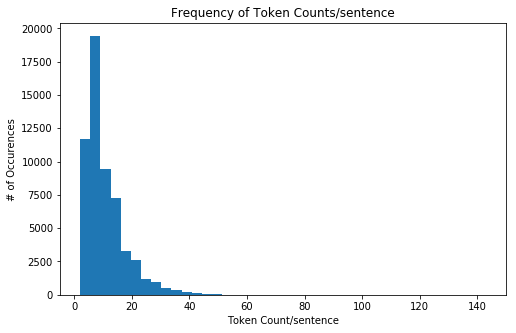

In [19]:
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline

# compute no. of words in each question
word_cnt = [len(tokenizer.tokenize(sentence)) for sentence in df['sentence'].tolist()]
# Plot the distribution
plt.figure(figsize=[8,5])
plt.hist(word_cnt, bins = 40)
plt.xlabel('Token Count/sentence')
plt.ylabel('# of Occurences')
plt.title("Frequency of Token Counts/sentence")
plt.show()

### Special Tokens




**`[SEP]`**

At the end of every sentence, we need to append the special `[SEP]` token. 

This token is an artifact of two-sentence tasks, where BERT is given two separate sentences and asked to determine something (e.g., can the answer to the question in sentence A be found in sentence B?). 

I am not certain yet why the token is still required when we have only single-sentence input, but it is!


**`[CLS]`**

For classification tasks, we must prepend the special `[CLS]` token to the beginning of every sentence.

This token has special significance. BERT consists of 12 Transformer layers. Each transformer takes in a list of token embeddings, and produces the same number of embeddings on the output (but with the feature values changed, of course!).

![Illustration of CLS token purpose](http://www.mccormickml.com/assets/BERT/CLS_token_500x606.png)

On the output of the final (12th) transformer, *only the first embedding (corresponding to the [CLS] token) is used by the classifier*.

>  "The first token of every sequence is always a special classification token (`[CLS]`). The final hidden state
corresponding to this token is used as the aggregate sequence representation for classification
tasks." (from the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf))

You might think to try some pooling strategy over the final embeddings, but this isn't necessary. Because BERT is trained to only use this [CLS] token for classification, we know that the model has been motivated to encode everything it needs for the classification step into that single 768-value embedding vector. It's already done the pooling for us!



### Sentence Length & Attention Mask



The sentences in our dataset obviously have varying lengths, so how does BERT handle this?

BERT has two constraints:
1. All sentences must be padded or truncated to a single, fixed length.
2. The maximum sentence length is 512 tokens.

Padding is done with a special `[PAD]` token, which is at index 0 in the BERT vocabulary. The below illustration demonstrates padding out to a "MAX_LEN" of 8 tokens.

<img src="http://www.mccormickml.com/assets/BERT/padding_and_mask.png" width="600">

The "Attention Mask" is simply an array of 1s and 0s indicating which tokens are padding and which aren't (seems kind of redundant, doesn't it?!). This mask tells the "Self-Attention" mechanism in BERT not to incorporate these PAD tokens into its interpretation of the sentence.

The maximum length does impact training and evaluation speed, however. 
For example, with a Tesla K80:

`MAX_LEN = 128  -->  Training epochs take ~5:28 each`

`MAX_LEN = 64   -->  Training epochs take ~2:57 each`







## 3.3. Tokenize Dataset

The transformers library provides a helpful `encode` function which will handle most of the parsing and data prep steps for us.

Before we are ready to encode our text, though, we need to decide on a **maximum sentence length** for padding / truncating to.

The below cell will perform one tokenization pass of the dataset in order to measure the maximum sentence length.

In [20]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  93


Just in case there are some longer test sentences, I'll set the maximum length to 64.


Now we're ready to perform the real tokenization.

The `tokenizer.encode_plus` function combines multiple steps for us:

1. Split the sentence into tokens.
2. Add the special `[CLS]` and `[SEP]` tokens.
3. Map the tokens to their IDs.
4. Pad or truncate all sentences to the same length.
5. Create the attention masks which explicitly differentiate real tokens from `[PAD]` tokens.

The first four features are in `tokenizer.encode`, but I'm using `tokenizer.encode_plus` to get the fifth item (attention masks). Documentation is [here](https://huggingface.co/transformers/main_classes/tokenizer.html?highlight=encode_plus#transformers.PreTrainedTokenizer.encode_plus).


In [21]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = MAX_LENGTH,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Original:  Ох, вот оно, 74.
Token IDs: tensor([  101, 10318,   128, 19030, 13322,   128, 13047,   132,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0])


## 3.4. Training & Validation Split


Divide up our training set to use 90% for training and 10% for validation.

In [22]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

16,800 training samples
1,867 validation samples


We'll also create an iterator for our dataset using the torch DataLoader class. This helps save on memory during training because, unlike a for loop, with an iterator the entire dataset does not need to be loaded into memory.

In [23]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it 
# here. For fine-tuning BERT on a specific task, the authors recommend a batch 
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order. 
train_dataloader = DataLoader(
    train_dataset,  # The training samples.
    sampler = RandomSampler(train_dataset), # Select batches randomly
    batch_size = batch_size # Trains with this batch size.
)

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
    val_dataset, # The validation samples.
    sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
    batch_size = batch_size # Evaluate with this batch size.
)

# 4. Train Our Classification Model

Now that our input data is properly formatted, it's time to fine tune the BERT model. 

## 4.1. BertForSequenceClassification

For this task, we first want to modify the pre-trained BERT model to give outputs for classification, and then we want to continue training the model on our dataset until that the entire model, end-to-end, is well-suited for our task. 

Thankfully, the huggingface pytorch implementation includes a set of interfaces designed for a variety of NLP tasks. Though these interfaces are all built on top of a trained BERT model, each has different top layers and output types designed to accomodate their specific NLP task.  

Here is the current list of classes provided for fine-tuning:
* BertModel
* BertForPreTraining
* BertForMaskedLM
* BertForNextSentencePrediction
* **BertForSequenceClassification** - The one we'll use.
* BertForTokenClassification
* BertForQuestionAnswering

The documentation for these can be found under [here](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html).



We'll be using [BertForSequenceClassification](https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#bertforsequenceclassification). This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained on our specific task. 


OK, let's load BERT! There are a few different pre-trained BERT models available. "bert-base-uncased" means the version that has only lowercase letters ("uncased") and is the smaller version of the two ("base" vs "large").

The documentation for `from_pretrained` can be found [here](https://huggingface.co/transformers/v2.2.0/main_classes/model.html#transformers.PreTrainedModel.from_pretrained), with the additional parameters defined [here](https://huggingface.co/transformers/v2.2.0/main_classes/configuration.html#transformers.PretrainedConfig).

In [24]:
#torch.cuda.empty_cache()

In [25]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single 
# linear classification layer on top. 
model = BertForSequenceClassification.from_pretrained(
    "DeepPavlov/rubert-base-cased",
    num_labels = 2,
)

# Tell pytorch to run this model on the GPU.
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(119547, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elemen

Just for curiosity's sake, we can browse all of the model's parameters by name here.

In the below cell, I've printed out the names and dimensions of the weights for:

1. The embedding layer.
2. The first of the twelve transformers.
3. The output layer.




In [26]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 201 different named parameters.

==== Embedding Layer ====

bert.embeddings.word_embeddings.weight                  (119547, 768)
bert.embeddings.position_embeddings.weight                (512, 768)
bert.embeddings.token_type_embeddings.weight                (2, 768)
bert.embeddings.LayerNorm.weight                              (768,)
bert.embeddings.LayerNorm.bias                                (768,)

==== First Transformer ====

bert.encoder.layer.0.attention.self.query.weight          (768, 768)
bert.encoder.layer.0.attention.self.query.bias                (768,)
bert.encoder.layer.0.attention.self.key.weight            (768, 768)
bert.encoder.layer.0.attention.self.key.bias                  (768,)
bert.encoder.layer.0.attention.self.value.weight          (768, 768)
bert.encoder.layer.0.attention.self.value.bias                (768,)
bert.encoder.layer.0.attention.output.dense.weight        (768, 768)
bert.encoder.layer.0.attention.output.dense.bias              

## 4.2. Optimizer & Learning Rate Scheduler

Now that we have our model loaded we need to grab the training hyperparameters from within the stored model.

For the purposes of fine-tuning, the authors recommend choosing from the following values (from Appendix A.3 of the [BERT paper](https://arxiv.org/pdf/1810.04805.pdf)):

>- **Batch size:** 16, 32  
- **Learning rate (Adam):** 5e-5, 3e-5, 2e-5  
- **Number of epochs:** 2, 3, 4 

We chose:
* Batch size: 32 (set when creating our DataLoaders)
* Learning rate: 2e-5
* Epochs: 4 (we'll see that this is probably too many...)

The epsilon parameter `eps = 1e-8` is "a very small number to prevent any division by zero in the implementation" (from [here](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/)).

You can find the creation of the AdamW optimizer in `run_glue.py` [here](https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L109).

In [27]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch) 
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


In [33]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4. 
# We chose to run for 2, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs]. 
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

## 4.3. Training Loop

Below is our training loop. There's a lot going on, but fundamentally for each pass in our loop we have a trianing phase and a validation phase. 

> *Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing the insights and code for using validation loss to detect over-fitting!*

**Training:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. 
    - In pytorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
- Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

**Evalution:**
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

Pytorch hides all of the detailed calculations from us, but we've commented the code to point out which of the above steps are happening on each line. 

> *PyTorch also has some [beginner tutorials](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#sphx-glr-beginner-blitz-cifar10-tutorial-py) which you may also find helpful.*

Define a helper function for calculating accuracy.

In [34]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

Helper function for formatting elapsed times as `hh:mm:ss`


In [35]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))
    
    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


We're ready to kick off the training!

In [36]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss, 
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):
    
    # ========================================
    #               Training
    # ========================================
    
    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to 
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)
            
            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the 
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because 
        # accumulating the gradients is "convenient while training RNNs". 
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()        

        # Perform a forward pass (evaluate the model on this training batch).
        # The documentation for this `model` function is here: 
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        # It returns different numbers of parameters depending on what arguments
        # arge given and what flags are set. For our useage here, it returns
        # the loss (because we provided labels) and the "logits"--the model
        # outputs prior to activation.
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
        
        #print(loss, logits)

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value 
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))
        
    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        
        # Unpack this training batch from our dataloader. 
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using 
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids 
        #   [1]: attention masks
        #   [2]: labels 
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():        

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which 
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            # The documentation for this `model` function is here: 
            # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
            # Get the "logits" output by the model. The "logits" are the output
            # values prior to applying an activation function like the softmax.
            (loss, logits) = model(b_input_ids, 
                                   token_type_ids=None, 
                                   attention_mask=b_input_mask,
                                   labels=b_labels)
            
        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)
    
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of    525.    Elapsed: 0:00:12.
  Batch    80  of    525.    Elapsed: 0:00:24.
  Batch   120  of    525.    Elapsed: 0:00:35.
  Batch   160  of    525.    Elapsed: 0:00:47.
  Batch   200  of    525.    Elapsed: 0:00:59.
  Batch   240  of    525.    Elapsed: 0:01:10.
  Batch   280  of    525.    Elapsed: 0:01:23.
  Batch   320  of    525.    Elapsed: 0:01:35.
  Batch   360  of    525.    Elapsed: 0:01:46.
  Batch   400  of    525.    Elapsed: 0:01:58.
  Batch   440  of    525.    Elapsed: 0:02:10.
  Batch   480  of    525.    Elapsed: 0:02:21.
  Batch   520  of    525.    Elapsed: 0:02:33.

  Average training loss: 0.55
  Training epcoh took: 0:02:35

Running Validation...
  Accuracy: 0.57
  Validation Loss: 0.76
  Validation took: 0:00:05

======== Epoch 2 / 4 ========
Training...
  Batch    40  of    525.    Elapsed: 0:00:12.
  Batch    80  of    525.    Elapsed: 0:00:24.
  Batch   120  of    525.    Elapsed: 0:00:35.
  Batch  

Let's view the summary of the training process.

In [39]:
import pandas as pd

# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# Display the table.
df_stats

,Training Loss,Training Time,Valid. Accur.,Valid. Loss,Validation Time
epoch,,,,,
1,0.55,0:02:35,0.57,0.76,0:00:05
2,0.45,0:02:36,0.56,0.89,0:00:05
3,0.41,0:02:38,0.58,0.86,0:00:05
4,0.31,0:02:37,0.57,1.02,0:00:05


Notice that, while the the training loss is going down with each epoch, the validation loss is increasing! This suggests that we are training our model too long, and it's over-fitting on the training data. 

(For reference, we are using 7,695 training samples and 856 validation samples).

Validation Loss is a more precise measure than accuracy, because with accuracy we don't care about the exact output value, but just which side of a threshold it falls on. 

If we are predicting the correct answer, but with less confidence, then validation loss will catch this, while accuracy will not.

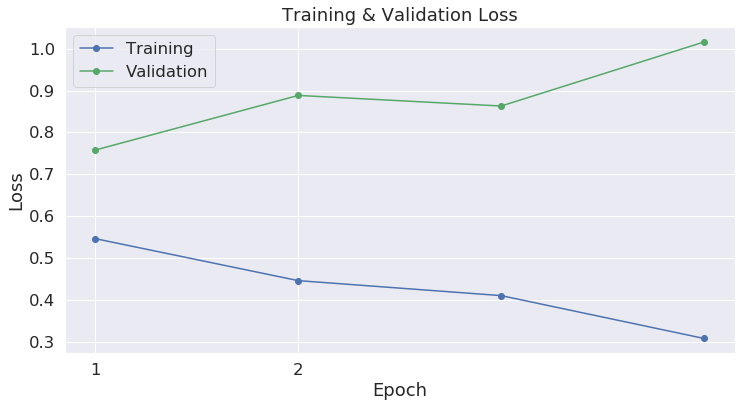

In [40]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2])

plt.show()

### SAVE MODEL

In [41]:
OUTPUT_DIR = './model_save'
import os
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(OUTPUT_DIR)
tokenizer.save_pretrained(OUTPUT_DIR)

('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

# 5. Performance On Test Set

Now we'll load the holdout dataset and prepare inputs just as we did with the training set. Then we'll evaluate predictions using [Matthew's correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html) because this is the metric used by the wider NLP community to evaluate performance on CoLA. With this metric, +1 is the best score, and -1 is the worst score. This way, we can see how well we perform against the state of the art models for this specific task.

### 5.1. Data Preparation



We'll need to apply all of the same steps that we did for the training data to prepare our test data set.

In [42]:
from rusenttokenize import ru_sent_tokenize
filename = "./style_transfer_sirius2021summer/data/generated/phoebe.txt"
with open(filename) as f:
    phoebe_replics = f.readlines()

phoebe_replics = [replic.strip() for replic in phoebe_replics]

phoebe_evaluation_dict = dict()
for replic in phoebe_replics:
    for sentence in ru_sent_tokenize(replic):
        phoebe_evaluation_dict[sentence] = -1

In [113]:
# phoebe_evaluation_dict

In [112]:
import pandas as pd

df_eval_phoebe = pd.DataFrame(columns=["sentence", 'label'])
df_eval_phoebe['sentence'] = phoebe_evaluation_dict.keys()
df_eval_phoebe["sentence"] = df_eval_phoebe["sentence"].apply(lambda x: x.strip())
df_eval_phoebe["label"] = 1
df_eval_phoebe = pd.concat([df_eval_phoebe, df_phoebe[['label','sentence']].sample(n=200, random_state=1)]).reset_index(drop=True)
df_eval_phoebe = df_eval_phoebe.sample(frac=1)
df_eval_phoebe.shape

/home/sirius/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  import sys


(349, 2)

In [83]:
import pandas as pd

# Report the number of sentences.
print('Number of test sentences: {:,}\n'.format(df_eval_phoebe.shape[0]))

# Create sentence and label lists
sentences = df_eval_phoebe.sentence.values
labels = df_eval_phoebe.label.values

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )
    
    # Add the encoded sentence to the list.    
    input_ids.append(encoded_dict['input_ids'])
    
    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Set the batch size.  
batch_size = 32  

# Create the DataLoader.
prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 349



## 5.2. Evaluate on Test Set



With the test set prepared, we can apply our fine-tuned model to generate predictions on the test set.

In [84]:
# Prediction on test set

print('Predicting labels for {:,} test sentences...'.format(len(input_ids)))

# Put model in evaluation mode
model.eval()

# Tracking variables 
predictions , true_labels = [], []

# Predict 
for batch in prediction_dataloader:
  # Add batch to GPU
  batch = tuple(t.to(device) for t in batch)
  
  # Unpack the inputs from our dataloader
  b_input_ids, b_input_mask, b_labels = batch
  
  # Telling the model not to compute or store gradients, saving memory and 
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids, token_type_ids=None, 
                      attention_mask=b_input_mask)

  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()
  
  # Store predictions and true labels
  predictions.append(logits)
  true_labels.append(label_ids)

print('    DONE.')

Predicting labels for 349 test sentences...
    DONE.


In [107]:
predictions_lst = []
for i in predictions:
    predictions_lst += i.tolist()
predictions_lst= np.array(predictions_lst)
predictions_lst = np.argmax(predictions_lst,  axis=1).flatten()

true_labels_lst = []
for i in true_labels:
    true_labels_lst += i.tolist()
true_labels_lst= np.array(true_labels_lst)

In [111]:
(predictions_lst == true_labels_lst).sum() / true_labels_lst.shape[0]

0.6819484240687679

In [114]:
matthews_corrcoef(predictions_lst, true_labels_lst)

0.36388715576785297

In [130]:
pearsonr(predictions_lst, true_labels_lst)[0]

0.3638871557678529

In [121]:
predictions_lst.mean()

0.49570200573065903

In [122]:
true_labels_lst.mean()

0.498567335243553

In [128]:
from scipy.stats import ttest_ind
ttest_ind(predictions_lst, true_labels_lst)

Ttest_indResult(statistic=-0.07559413589505624, pvalue=0.9397637247193945)

Accuracy on the CoLA benchmark is measured using the "[Matthews correlation coefficient](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.matthews_corrcoef.html)" (MCC).

We use MCC here because the classes are imbalanced:


In [73]:
#print('Positive samples: %d of %d (%.2f%%)' % (df.label.sum(), len(df.label), (df.label.sum() / len(df.label) * 100.0)))

In [86]:
from sklearn.metrics import matthews_corrcoef
import numpy as np

matthews_set = []

# Evaluate each test batch using Matthew's correlation coefficient
print('Calculating Matthews Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)                
  matthews_set.append(matthews)

Calculating Matthews Corr. Coef. for each batch...


In [87]:
from scipy.stats import pearsonr

pearsonr_set = []

print('Calculating Pearson Corr. Coef. for each batch...')

# For each input batch...
for i in range(len(true_labels)):
  
  # The predictions for this batch are a 2-column ndarray (one column for "0" 
  # and one column for "1"). Pick the label with the highest value and turn this
  # in to a list of 0s and 1s.
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  
  # Calculate and store the coef for this batch.  
  pearsonrs = pearsonr(true_labels[i], pred_labels_i)                
  pearsonr_set.append(pearsonrs)

Calculating Pearson Corr. Coef. for each batch...


In [88]:
i=2
pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
print(pred_labels_i)
print(true_labels[3])

pearsonr(true_labels[i], pred_labels_i)

[1 1 0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 1 1 1 0 0 1 1 1 1 0 1 1 0 0]
[0 0 0 0 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 0 0 0 1 0 1 1 0 1 1 1 0 1]


(0.32277655457716287, 0.07157220501042462)

The final score will be based on the entire test set, but let's take a look at the scores on the individual batches to get a sense of the variability in the metric between batches. 

Each batch has 32 sentences in it, except the last batch which has only (516 % 32) = 4 test sentences in it.


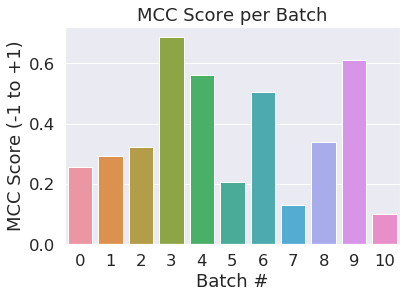

In [89]:
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
# Create a barplot showing the MCC score for each batch of test samples.
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)

plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch #')

plt.show()

Now we'll combine the results for all of the batches and calculate our final MCC score.

In [63]:
# Combine the results across all batches. 
flat_predictions = np.concatenate(predictions, axis=0)

# For each sample, pick the label (0 or 1) with the higher score.
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Combine the correct labels for each batch into a single list.
flat_true_labels = np.concatenate(true_labels, axis=0)

# Calculate the MCC
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)

print('Total MCC: %.3f' % mcc)

Total MCC: 0.000


/home/sirius/anaconda3/lib/python3.7/site-packages/sklearn/metrics/_classification.py:873: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


Cool! In about half an hour and without doing any hyperparameter tuning (adjusting the learning rate, epochs, batch size, ADAM properties, etc.) we are able to get a good score. 

> *Note: To maximize the score, we should remove the "validation set" (which we used to help determine how many epochs to train for) and train on the entire training set.*

The library documents the expected accuracy for this benchmark [here](https://huggingface.co/transformers/examples.html#glue) as `49.23`.

You can also look at the official leaderboard [here](https://gluebenchmark.com/leaderboard/submission/zlssuBTm5XRs0aSKbFYGVIVdvbj1/-LhijX9VVmvJcvzKymxy). 

Note that (due to the small dataset size?) the accuracy can vary significantly between runs.


# Conclusion

This post demonstrates that with a pre-trained BERT model you can quickly and effectively create a high quality model with minimal effort and training time using the pytorch interface, regardless of the specific NLP task you are interested in.

# Appendix


## A1. Saving & Loading Fine-Tuned Model

This first cell (taken from `run_glue.py` [here](https://github.com/huggingface/transformers/blob/35ff345fc9df9e777b27903f11fa213e4052595b/examples/run_glue.py#L495)) writes the model and tokenizer out to disk.

In [ ]:
import os

# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/vocab.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

Let's check out the file sizes, out of curiosity.

In [ ]:
!ls -l --block-size=K ./model_save/

total 427960K
-rw-r--r-- 1 root root      2K Mar 18 15:53 config.json
-rw-r--r-- 1 root root 427719K Mar 18 15:53 pytorch_model.bin
-rw-r--r-- 1 root root      1K Mar 18 15:53 special_tokens_map.json
-rw-r--r-- 1 root root      1K Mar 18 15:53 tokenizer_config.json
-rw-r--r-- 1 root root    227K Mar 18 15:53 vocab.txt


The largest file is the model weights, at around 418 megabytes.

In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 418M Mar 18 15:53 ./model_save/pytorch_model.bin


To save your model across Colab Notebook sessions, download it to your local machine, or ideally copy it to your Google Drive.

In [ ]:
# Mount Google Drive to this Notebook instance.
from google.colab import drive
    drive.mount('/content/drive')

In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ "./drive/Shared drives/ChrisMcCormick.AI/Blog Posts/BERT Fine-Tuning/"

The following functions will load the model back from disk.

In [ ]:
# Load a trained model and vocabulary that you have fine-tuned
model = model_class.from_pretrained(output_dir)
tokenizer = tokenizer_class.from_pretrained(output_dir)

# Copy the model to the GPU.
model.to(device)

## A.2. Weight Decay



The huggingface example includes the following code block for enabling weight decay, but the default decay rate is "0.0", so I moved this to the appendix.

This block essentially tells the optimizer to not apply weight decay to the bias terms (e.g., $ b $ in the equation $ y = Wx + b $ ). Weight decay is a form of regularization--after calculating the gradients, we multiply them by, e.g., 0.99.

In [ ]:
# This code is taken from:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L102

# Don't apply weight decay to any parameters whose names include these tokens.
# (Here, the BERT doesn't have `gamma` or `beta` parameters, only `bias` terms)
no_decay = ['bias', 'LayerNorm.weight']

# Separate the `weight` parameters from the `bias` parameters. 
# - For the `weight` parameters, this specifies a 'weight_decay_rate' of 0.01. 
# - For the `bias` parameters, the 'weight_decay_rate' is 0.0. 
optimizer_grouped_parameters = [
    # Filter for all parameters which *don't* include 'bias', 'gamma', 'beta'.
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.1},
    
    # Filter for parameters which *do* include those.
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

# Note - `optimizer_grouped_parameters` only includes the parameter values, not 
# the names.

# Revision History

**Version 3** - *Mar 18th, 2020* - (current)
* Simplified the tokenization and input formatting (for both training and test) by leveraging the `tokenizer.encode_plus` function. 
`encode_plus` handles padding *and* creates the attention masks for us.
* Improved explanation of attention masks.
* Switched to using `torch.utils.data.random_split` for creating the training-validation split.
* Added a summary table of the training statistics (validation loss, time per epoch, etc.).
* Added validation loss to the learning curve plot, so we can see if we're overfitting. 
    * Thank you to [Stas Bekman](https://ca.linkedin.com/in/stasbekman) for contributing this!
* Displayed the per-batch MCC as a bar plot.

**Version 2** - *Dec 20th, 2019* - [link](https://colab.research.google.com/drive/1Y4o3jh3ZH70tl6mCd76vz_IxX23biCPP)
* huggingface renamed their library to `transformers`. 
* Updated the notebook to use the `transformers` library.

**Version 1** - *July 22nd, 2019*
* Initial version.

## Further Work

* It might make more sense to use the MCC score for “validation accuracy”, but I’ve left it out so as not to have to explain it earlier in the Notebook.
* Seeding -- I’m not convinced that setting the seed values at the beginning of the training loop is actually creating reproducible results…
* The MCC score seems to vary substantially across different runs. It would be interesting to run this example a number of times and show the variance.
